# Case study
#### Using RISF on real life data from bus sensors

## DATA MANIPULATION

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
import datetime
import pickle
# from risf import *

from risf.risf_data import *
from risf.distance_functions import *
from risf.forest import RandomIsolationSimilarityForest

# from risf.distance import *
# from risf.forest import *
# from risf.splitting import *
# from risf.tree import *

In [2]:
# Timestamp conversion copied from buses-data-demo.ipynb
VACT_EPOCH = datetime.datetime(year=2011,month=6,day=16,hour=5,minute=23,second=0)
VACT_TIMESTAMP = 1308194580
assert datetime.datetime.fromtimestamp(VACT_TIMESTAMP) == VACT_EPOCH
MILISECOND = 1
SECOND = 1000 * MILISECOND
HOUR = 3600*SECOND
DAY = 24*HOUR
def getVactDate(value):
    return VACT_EPOCH + datetime.timedelta(milliseconds=int(value))

In [3]:
# Loading pandas DataFrame with recorded values from sensors and
# Adding column with transformed timestamp
# Note that this data is ignored by git, so you have to make a copy on your own
# Also the excel file seems to only contain data about the bus number 369
# TODO Remove these links
# Link to data:
# https://halmstaduniversity.box.com/s/rtm3o8dzdt4o0hxr5sredhb1y06qsi8u

DATA_369 = pickle.load(open("../data/bus/data-369.pickle","rb"))
DATA_370 = pickle.load(open("../data/bus/data-370.pickle","rb"))
DATA_371 = pickle.load(open("../data/bus/data-371.pickle","rb"))
DATA_372 = pickle.load(open("../data/bus/data-372.pickle","rb"))
DATA_375 = pickle.load(open("../data/bus/data-375.pickle","rb"))


In [4]:
DATA_369.insert(0, 'tstamp', DATA_369.Timestamp.apply(getVactDate))
DATA_370.insert(0, 'tstamp', DATA_370.Timestamp.apply(getVactDate))
DATA_371.insert(0, 'tstamp', DATA_371.Timestamp.apply(getVactDate))
DATA_372.insert(0, 'tstamp', DATA_372.Timestamp.apply(getVactDate))
DATA_375.insert(0, 'tstamp', DATA_375.Timestamp.apply(getVactDate))

In [5]:
DATA_369 = DATA_369.set_index('tstamp')
DATA_369.sort_index(inplace = True)
DATA_370 = DATA_370.set_index('tstamp')
DATA_370.sort_index(inplace = True)
DATA_371 = DATA_371.set_index('tstamp')
DATA_371.sort_index(inplace = True)
DATA_372 = DATA_372.set_index('tstamp')
DATA_372.sort_index(inplace = True)
DATA_375 = DATA_375.set_index('tstamp')
DATA_375.sort_index(inplace = True)

In [6]:
DATA_369.drop(columns=['Timestamp'], inplace = True)
DATA_370.drop(columns=['Timestamp'], inplace = True)
DATA_371.drop(columns=['Timestamp'], inplace = True)
DATA_372.drop(columns=['Timestamp'], inplace = True)
DATA_375.drop(columns=['Timestamp'], inplace = True)

In [7]:
# Example DataFrame
DATA_369.head()

,WetTankAirPressure,LongitudAcc,EngineSpeed,Fuel Rate,Engine Load,Boost Pressure,EngineAirInletPressure,AcceleratorPedalPos,VehicleSpeed,BrakePedalPos
tstamp,,,,,,,,,,
2012-04-15 08:23:47.763,4.2749,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
2012-04-15 08:23:48.457,4.2749,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
2012-04-15 08:23:49.550,4.2749,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
2012-04-15 08:23:50.715,4.2749,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
2012-04-15 08:23:51.435,4.2749,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0


In [8]:
def generate_window_iterator(start, end, freq):
    current_timestamp = start
    
    while current_timestamp + freq <= end:
        yield current_timestamp
        current_timestamp += freq

def extract_time_windows(dataframe, window_size, timestamp = False, **kwargs):

    window_iterator = generate_window_iterator(**kwargs)
    
    for start_timestamp in window_iterator:
        end_timestamp = start_timestamp + window_size
        if timestamp:
            yield (start_timestamp, dataframe.loc[start_timestamp:end_timestamp])
            continue
        yield dataframe.loc[start_timestamp:end_timestamp]

#### Sample window generating and cardinality calculation

In [9]:
# Example usage of extract_time_windows
# It creates windows of length
START = pd.Timestamp('2012-04-15 08:23:47.763000') # Earlisest time stamp
END = pd.Timestamp('2014-01-31 19:27:10.884000') # Latest time stamp
FREQ = pd.Timedelta('3T')
WINDOW_SIZE = pd.Timedelta('4T')

l = []
s = {}
for win in extract_time_windows(DATA_369, WINDOW_SIZE, start=START, end=END, freq=FREQ):
    key = win.shape[0] 
    if key not in s:
       s[key] = 1
    else:
       s[key] += 1  


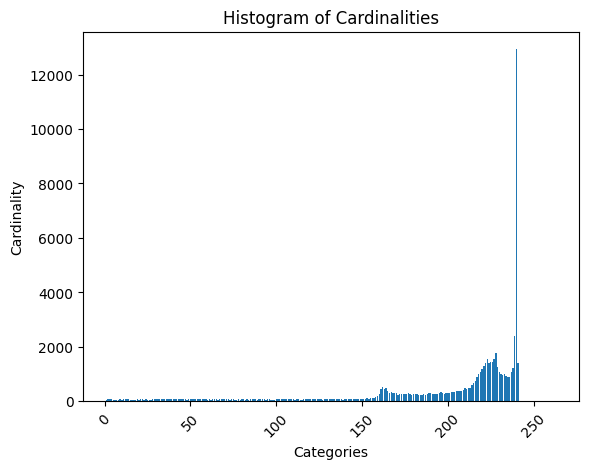

In [10]:
import matplotlib.pyplot as plt

# Sample dictionary

# Extract keys and values from the dictionary
categories = [x for x in sorted(s) if x ]
cardinalities = [s[x] for x in sorted(s) if x ]

# Plotting the histogram
plt.bar(categories, cardinalities)

# Adding labels and title
plt.xlabel('Categories')
plt.ylabel('Cardinality')
plt.title('Histogram of Cardinalities')

# Rotating the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()

## REPRESENTATIONS

#### Numeric

In [11]:
# Inspired by the LSTM paper

# For every column in given window calculate:
#
#   mean
#   std
#   skewness
#   kurtosis
#   min
#   quantiles (first, second and third)
#   max
#   deciles
#
# Returns: 
# List of np arrays with measurements for one column

In [12]:
def get_numeric_from_window(window):
    measurements = []
    for sensor in window.columns:
        mean = window[sensor].mean()
        std = window[sensor].std()
        skewness = skew(window[sensor])
        kurt = kurtosis(window[sensor])
        quantiles = np.percentile(window[sensor], [0, 25, 50, 75, 100])
        deciles = np.percentile(window[sensor], range(10, 100, 10))
        # END OF CALCULATIONS
        sensor_measurements = np.concatenate(([mean, std, skewness, kurt], quantiles, deciles))
        measurements.append(sensor_measurements)
    return measurements


In [13]:
# Example usage of get_numeric_from_window

START = pd.Timestamp('2012-04-15 08:23:47.763000') # Start of data, first recorded day of 2012
END = pd.Timestamp('2012-12-31 23:59:59.999') # End of 2012
FREQ = pd.Timedelta('4T')
WINDOW_SIZE = pd.Timedelta('4T')

RESULTING_DATA = []

for win in extract_time_windows(DATA_369, WINDOW_SIZE, start=START, end=END, freq=FREQ):
    n = win.shape[0]
    if n < 20:
        continue
    RESULTING_DATA.append(get_numeric_from_window(win))


/tmp/ipykernel_135402/1779284485.py:6: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness = skew(window[sensor])
/tmp/ipykernel_135402/1779284485.py:7: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt = kurtosis(window[sensor])


In [14]:
len(RESULTING_DATA)

13006

In [15]:
RESULTING_DATA[0][0]

array([ 6.42293568,  1.33920562, -0.23688153, -1.11239065,  4.2749    ,
        5.44705   ,  6.55025   ,  7.5845    ,  8.61875   ,  4.2749    ,
        5.17125   ,  5.58495   ,  6.13655   ,  6.55025   ,  6.96395   ,
        7.37765   ,  7.65345   ,  8.1361    ])

In [16]:
# Sanity check
for win in extract_time_windows(DATA_369, WINDOW_SIZE, start=START, end=END, freq=FREQ):
    n = win.shape[0]
    if n < 20:
        continue
    pp = win.iloc[:,0].describe()
    break
pp

count    241.000000
mean       6.422936
std        1.339206
min        4.274900
25%        5.447050
50%        6.550250
75%        7.584500
max        8.618750
Name: WetTankAirPressure, dtype: float64

#### Histogram

In [17]:
# Funciton that applied to a window will produce histograms of every column
# If way_of_binarization is not None, this function will be applied to every column to calculate number of bins
# If it is None np.histogram() auto bins will be used

# Returns: 
# List of touples (bins,counts) for each column

In [18]:
def get_histograms_from_window(window, way_of_binarization=None):
    histograms = []
    for sensor in window.columns:
        column_data = window[sensor]
        
        if way_of_binarization is None:
            hist, bins = np.histogram(column_data, bins='auto')
        else:
            bins = way_of_binarization(column_data)
            hist, bins = np.histogram(column_data, bins=bins)
            
        histograms.append((bins, hist))
    return histograms

In [19]:
# Example usage of get_histograms_from_window

def bins_eq_10 (column): return 10 # Function applied to every column of the winow DataFrame to get number of bins/bins
START = pd.Timestamp('2012-04-15 08:23:47.763000') # Start of data, first recorded day of 2012
END = pd.Timestamp('2012-12-31 23:59:59.999') # End of 2012
FREQ = pd.Timedelta('4T')
WINDOW_SIZE = pd.Timedelta('4T')

RESULTING_DATA = []

for win in extract_time_windows(DATA_369, WINDOW_SIZE, start=START, end=END, freq=FREQ):
    n = win.shape[0]
    if n < 20:
        continue
    RESULTING_DATA.append(get_histograms_from_window(win, way_of_binarization=bins_eq_10))


In [20]:
len(RESULTING_DATA)

13006

In [21]:
RESULTING_DATA[0][0]

(array([4.2749  , 4.709285, 5.14367 , 5.578055, 6.01244 , 6.446825,
        6.88121 , 7.315595, 7.74998 , 8.184365, 8.61875 ]),
 array([42,  6, 22, 19, 26, 22, 28, 32, 21, 23]))

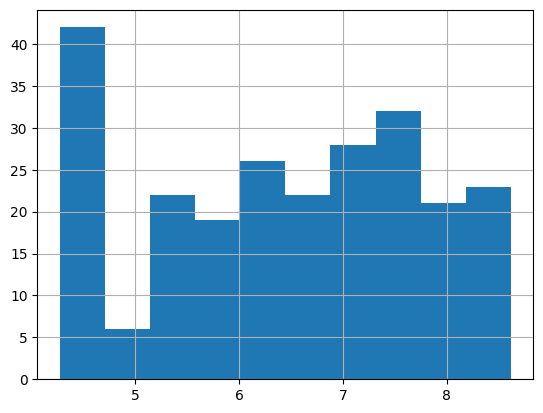

In [22]:
# Sanity check
for win in extract_time_windows(DATA_369, WINDOW_SIZE, start=START, end=END, freq=FREQ):
    n = win.shape[0]
    if n < 20:
        continue
    pp = win.iloc[:,0].hist()
    break

#### Time series

In [23]:
# Funciton that applied to a window will produce time series by calculating averages of provided size for every window

# Returns: 
# List of lists with values of averages from given time windows for each column

In [24]:
START = pd.Timestamp('2012-04-15 08:23:47.763000')
FREQ = pd.Timedelta('1T')
END = START + 30 * FREQ
essa_list = []
p = DATA_369.loc[START:END]['WetTankAirPressure'].resample(FREQ).mean()
essa_list.append(p.values)

In [25]:
print(essa_list)

[array([ 4.2749    ,  4.8368425 ,  6.24112417,  7.27307583,  8.26825417,
        9.21746583, 10.22413583, 11.1526625 , 10.018435  , 10.9044425 ,
       11.121635  , 10.928575  , 11.51005333, 11.04349167, 11.29630833,
       11.24114833, 10.9733925 , 10.75433649,         nan,         nan,
               nan,         nan,         nan, 10.542455  , 11.43931574,
       11.17359375, 11.32134375, 11.12030439, 11.34046053, 11.01695636,
       11.53815568])]


In [30]:
def get_time_series_from_window(window, start, window_size, AVG_SIZE='1S'):
    time_series = []

    for sensor in window.columns:
        cp = window[sensor].copy()
        cp.loc[start] = np.nan
        cp.loc[start+window_size] = np.nan
        averages = cp.resample(AVG_SIZE).mean()
        np.nan_to_num(averages, copy=False)
        time_series.append(averages)

    return time_series

In [31]:
# Example usage of get_time_series_from_window

START = pd.Timestamp('2012-04-15 08:23:47.763000') # Start of data, first recorded day of 2012
END = pd.Timestamp('2012-12-31 23:59:59.999') # End of 2012
FREQ = pd.Timedelta('4T')
WINDOW_SIZE = pd.Timedelta('4T')
AVG_SIZE = '2S'
RESULTING_DATA = []

for twin  in extract_time_windows(DATA_369, WINDOW_SIZE, timestamp=True, start=START, end=END, freq=FREQ):
    t, win = twin
    n = win.shape[0]
    if n < 20:
        continue
    RESULTING_DATA.append(get_time_series_from_window(win,t,WINDOW_SIZE,AVG_SIZE=AVG_SIZE))

In [32]:
len(RESULTING_DATA)

13006

In [33]:
len(RESULTING_DATA[0])

10

In [34]:
RESULTING_DATA[0][0]

tstamp
2012-04-15 08:23:46    0.000000
2012-04-15 08:23:48    4.274900
2012-04-15 08:23:50    4.274900
2012-04-15 08:23:52    4.274900
2012-04-15 08:23:54    4.274900
                         ...   
2012-04-15 08:27:38    8.446375
2012-04-15 08:27:40    8.480850
2012-04-15 08:27:42    8.515325
2012-04-15 08:27:44    8.549800
2012-04-15 08:27:46    8.584275
Freq: 2S, Name: WetTankAirPressure, Length: 121, dtype: float64

<Axes: xlabel='tstamp'>

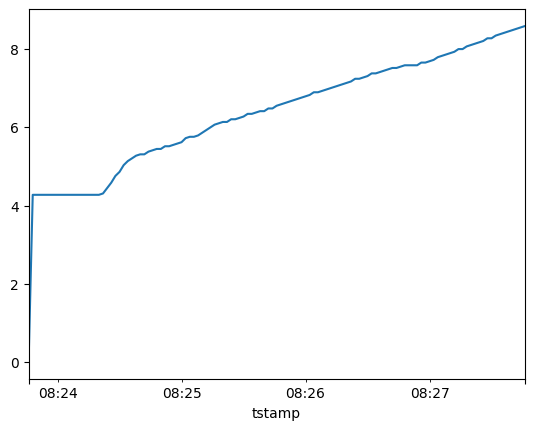

In [35]:
RESULTING_DATA[0][0].plot.line()

In [36]:
d = {}
for x in RESULTING_DATA:
    for y in x:
        l = len(y)
        if l not in d:
            d[l] = 1
        else:
            d[l]+=1
print(d)

{121: 130060}


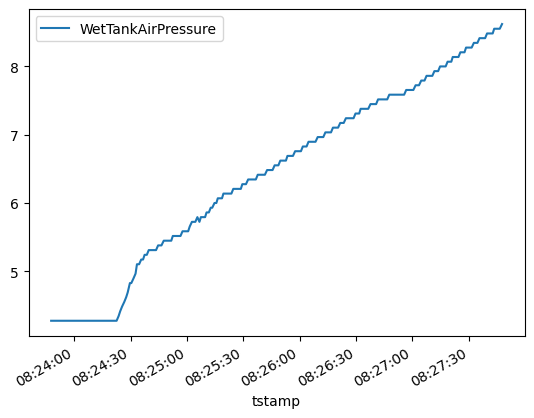

In [37]:
# Sanity check
for win in extract_time_windows(DATA_369, WINDOW_SIZE, start=START, end=END, freq=FREQ):
    n = win.shape[0]
    if n < 20:
        continue
    win.plot.line(y=win.columns[0])
    break

#### Example experiment 

In [39]:
columns = ['WetTankAirPressure', 'EngineAirInletPressure']

X_dfs = [DATA_370,DATA_371,DATA_372,DATA_375]
y_dfs = [DATA_369]

START = pd.Timestamp('2012-04-15 08:23:47.763000') 
END = START + pd.Timedelta('4W')

FREQ = pd.Timedelta('4T')  
WINDOW_SIZE = pd.Timedelta('4T')

def bin10(column): return 10
AVG_SIZE = '1S'

X_NUMERIC = []
X_HISTOGRAM = []
X_TSIRES = []

y_NUMERIC = []
y_HISTOGRAM = []
y_TSIRES = []
y_TSTAMPS = []

for X in X_dfs:
    for twin in extract_time_windows(X.loc[:,columns], WINDOW_SIZE, start=START, end=END, freq=FREQ, timestamp = True):
        t, win = twin
        n = win.shape[0]
        if n < 20:
            continue
        X_NUMERIC.append(get_numeric_from_window(win))
        X_HISTOGRAM.append(get_histograms_from_window(win, way_of_binarization=bin10))
        X_TSIRES.append(get_time_series_from_window(win,t,WINDOW_SIZE,AVG_SIZE=AVG_SIZE))


/tmp/ipykernel_135402/1779284485.py:6: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness = skew(window[sensor])
/tmp/ipykernel_135402/1779284485.py:7: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt = kurtosis(window[sensor])
/tmp/ipykernel_135402/1779284485.py:6: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness = skew(window[sensor])
/tmp/ipykernel_135402/1779284485.py:7: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt = kurtosis(window[sensor])


In [40]:
for y in y_dfs:
    for twin in extract_time_windows(y.loc[:,columns], WINDOW_SIZE, timestamp = True, start=START, end=END, freq=FREQ):
        t, win = twin
        n = win.shape[0]
        if n < 20:
            continue
        y_TSTAMPS.append(t)
        y_NUMERIC.append(get_numeric_from_window(win))
        y_HISTOGRAM.append(get_histograms_from_window(win, way_of_binarization=bin10))
        y_TSIRES.append(get_time_series_from_window(win,t,WINDOW_SIZE,AVG_SIZE=AVG_SIZE))

/tmp/ipykernel_135402/1779284485.py:6: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness = skew(window[sensor])
/tmp/ipykernel_135402/1779284485.py:7: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt = kurtosis(window[sensor])


In [41]:
X_NUMERIC = np.array(X_NUMERIC)
X_HISTOGRAM = np.array(X_HISTOGRAM, dtype = object)
X_TSIRES = np.array(X_TSIRES)
np.nan_to_num(X_NUMERIC, copy=False)

y_NUMERIC = np.array(y_NUMERIC)
y_HISTOGRAM = np.array(y_HISTOGRAM, dtype = object)
y_TSIRES = np.array(y_TSIRES)
np.nan_to_num(y_NUMERIC, copy=False)


array([[[ 6.42293568e+00,  1.33920562e+00, -2.36881528e-01, ...,
          7.37765000e+00,  7.65345000e+00,  8.13610000e+00],
        [ 9.96099585e+01,  7.94082541e-01, -1.53945692e+00, ...,
          1.00000000e+02,  1.00000000e+02,  1.00000000e+02]],

       [[ 1.01083573e+01,  9.86814684e-01,  1.24092755e-01, ...,
          1.08251500e+01,  1.11699000e+01,  1.15146500e+01],
        [ 1.00000000e+02,  0.00000000e+00,  0.00000000e+00, ...,
          1.00000000e+02,  1.00000000e+02,  1.00000000e+02]],

       [[ 1.10253923e+01,  6.75728190e-01, -8.10085668e-01, ...,
          1.15146500e+01,  1.15836000e+01,  1.17215000e+01],
        [ 1.00350000e+02,  1.43273154e+00,  5.40976025e+00, ...,
          1.00000000e+02,  1.00000000e+02,  1.00000000e+02]],

       ...,

       [[ 1.10629308e+01,  2.64435728e-01,  4.00457918e-01, ...,
          1.11699000e+01,  1.11699000e+01,  1.13767500e+01],
        [ 1.24046729e+02,  2.24151538e+01,  1.79519607e+00, ...,
          1.22200000e+02,  1.36800

In [43]:
from risf.risf_data import RisfData
from risf.distance_functions import * 

In [51]:
from risf.distance_functions import * 
ex_X = RisfData()
ex_y = RisfData()


class MyWasser():
    def __init__(self) -> None:
        self.results = {}

    def __call__(self, *args, **kwargs):
        return self.dist(*args, **kwargs)
    
    def dist(self, hist1, hist2):
        bins1, values1 = hist1
        bins2, values2 = hist2

        #dist = wasserstein_distance(values1, values2, bins1, bins2)
        dist = wasserstein_distance(values1, values2)
        self.results["dist"] = dist
        return dist

# class MyEuclidean():
#     def __init__(self) -> None:
#         self.results = {}

#     def __call__(self, *args, **kwargs):
#         return self.dist(*args, **kwargs)

#     def adjust(self, values1, bins1, values2, bins2):
#         min1, max1 = min(bins1), max(bins1)
#         min2, max2 = min(bins2), max(bins2)

#         bins = np.arange(min(min1, min2), max(max1, max2) + 1)

#         values1_new = [0] * len(bins)
#         for bin in bins1:
#             i = np.where(bins == bin)[0][0]
#             j = np.where(bins1 == bin)[0][0]
#             values1_new[i] = values1[j]
#         values2_new = [0] * len(bins)
#         for bin in bins2:
#             i = np.where(bins == bin)[0][0]
#             j = np.where(bins2 == bin)[0][0]
#             values2_new[i] = values2[j]
#         return values1_new, values2_new

#     def dist(self, hist1, hist2):
#         bins1, values1 = hist1
#         bins2, values2 = hist2
#         if not np.array_equal(bins1, bins2):
#             bins1, bins2 = np.array(bins1), np.array(bins2)
#             values1, values2 = self.adjust(values1, bins1, values2, bins2)
#         values1, values2 = np.array(values1), np.array(values2)

#         dist = np.linalg.norm(values1 - values2) ** 2
#         self.results["dist"] = dist
#         return dist


# distances_numerical = [SelectiveDistance(projection_func = euclidean_projection, min_n=1, max_n=3),
#                         SelectiveDistance(projection_func = cosine_projection, min_n=1, max_n=3)]

distances_histogram = [
    TrainDistanceMixin(distance = MyWasser()),
    ##TrainDistanceMixin(distance = MyEuclidean())
    ]

#distanecs_tser = [TrainDistanceMixin(distance = TSEuclidean())]

for i in range(len(columns)):
#     num_col = X_NUMERIC[:,i]
#     num_col = np.array(num_col)
#     ex_X.add_data(num_col, distances_numerical)
    hist_col = X_HISTOGRAM[:,i]
    hist_col = np.array(hist_col, dtype=object)
    ex_X.add_data(hist_col, distances_histogram)
    # tser_col = X_TSIRES[:,i]
    # tser_col = np.array(tser_col)
    # ex_X.add_data(tser_col, distanecs_tser)
    
    # num_col = y_NUMERIC[:,i]
    # num_col = np.array(num_col)
    # ex_y.add_data(num_col, distances_numerical)
    hist_col = y_HISTOGRAM[:,i]
    hist_col = np.array(hist_col, dtype=object)
    ex_y.add_data(hist_col, distances_histogram)
    # tser_col = y_TSIRES[:,i]
    # hist_col = np.array(tser_col)
    # ex_y.add_data(tser_col, distanecs_tser)


In [52]:
ex_X.precompute_distances()
ex_y.precompute_distances()

In [53]:
forest = RandomIsolationSimilarityForest(distances = ex_X.distances).fit(ex_X)

In [54]:
results = forest.predict(ex_y)

In [55]:
print(results)

[0 0 0 ... 0 0 0]


In [56]:
len(results)

2928

In [62]:
for x in range(0,len(results)):
    print(y_TSTAMPS[x],results[x])

2012-04-15 08:23:47.763000 0
2012-04-15 08:27:47.763000 0
2012-04-15 08:31:47.763000 0
2012-04-15 08:35:47.763000 1
2012-04-15 08:39:47.763000 0
2012-04-15 08:43:47.763000 0
2012-04-15 08:47:47.763000 0
2012-04-15 08:51:47.763000 0
2012-04-15 08:55:47.763000 0
2012-04-15 08:59:47.763000 0
2012-04-15 09:03:47.763000 0
2012-04-15 09:07:47.763000 0
2012-04-15 09:11:47.763000 0
2012-04-15 09:15:47.763000 0
2012-04-15 09:19:47.763000 0
2012-04-15 09:23:47.763000 0
2012-04-15 09:27:47.763000 0
2012-04-15 09:31:47.763000 0
2012-04-15 09:35:47.763000 0
2012-04-15 09:39:47.763000 0
2012-04-15 09:43:47.763000 0
2012-04-15 09:47:47.763000 0
2012-04-15 09:51:47.763000 0
2012-04-15 09:55:47.763000 0
2012-04-15 09:59:47.763000 0
2012-04-15 10:03:47.763000 0
2012-04-15 10:07:47.763000 0
2012-04-15 10:11:47.763000 0
2012-04-15 10:15:47.763000 0
2012-04-15 10:19:47.763000 0
2012-04-15 10:23:47.763000 0
2012-04-15 10:27:47.763000 0
2012-04-15 10:31:47.763000 0
2012-04-15 10:35:47.763000 0
2012-04-15 10:

In [ ]:
# compare with this: y_TSTAMPS

In [ ]:
# from risf.risf_data import RisfData
# from risf.distance import TrainDistanceMixin, SelectiveDistance # We will explain them later
# data = RisfData()

# categorical_feature = np.array([[0], [2], [1]])
# distances_categorical = [SelectiveDistance(projection_func = jaccard_projection, min_n=1, max_n=1)]
# data.add_data(categorical_feature, distances_categorical)

# numerical_features = np.random.randn(3, 3) # vector in R^3
# distances_numerical = [SelectiveDistance(projection_func = euclidean_projection, min_n=1, max_n=3),
#                         SelectiveDistance(projection_func = cosine_projection, min_n=1, max_n=3)]
# data.add_data(numerical_features, distances_numerical)

# set_features = np.array([{10, 20, 30}, {20, 30}, {10, 20}])
# distances_set = [TrainDistanceMixin(distance = jaccard_distance)]
# data.add_data(set_features, distances_set)

# graph_features = np.array([Graph(), Graph(), Graph()]) # Graph is just a dummy object
# distances_graph = [TrainDistanceMixin(distance = ipsen_mikailov), TrainDistanceMixin(distance = portrait)]
# data.add_data(graph_features, distances_graph)

In [ ]:
example_data = RisfData()




## Experiments

In [ ]:
# from risf.risf_data import RisfData
# from risf.distance import TrainDistanceMixin, SelectiveDistance # We will explain them later
# data = RisfData()

# categorical_feature = np.array([[0], [2], [1]])
# distances_categorical = [SelectiveDistance(projection_func = jaccard_projection, min_n=1, max_n=1)]
# data.add_data(categorical_feature, distances_categorical)

# numerical_features = np.random.randn(3, 3) # vector in R^3
# distances_numerical = [SelectiveDistance(projection_func = euclidean_projection, min_n=1, max_n=3),
#                         SelectiveDistance(projection_func = cosine_projection, min_n=1, max_n=3)]
# data.add_data(numerical_features, distances_numerical)

# set_features = np.array([{10, 20, 30}, {20, 30}, {10, 20}])
# distances_set = [TrainDistanceMixin(distance = jaccard_distance)]
# data.add_data(set_features, distances_set)

# graph_features = np.array([Graph(), Graph(), Graph()]) # Graph is just a dummy object
# distances_graph = [TrainDistanceMixin(distance = ipsen_mikailov), TrainDistanceMixin(distance = portrait)]
# data.add_data(graph_features, distances_graph)

In [ ]:
# from risf.forest import RandomIsolationSimilarityForest

# data = np.random.randn(100,10)
# forest = RandomIsolationSimilarityForest().fit(data)

In [ ]:
# forest = RandomIsolationSimilarityForest(distances = data.distances).fit(data)

In [ ]:
# TODO Remember about changing seed and keeping the seeds consistant
SEED = 23

In [ ]:
X = DATA_369['WetTankAirPressure'].values[:1000]
Y = DATA_369['WetTankAirPressure'].values[1000:2000]

In [ ]:
from risf.forest import RandomIsolationSimilarityForest

RISF = RandomIsolationSimilarityForest(random_state=SEED)

RISF.fit(X)

s = RISF.predict(Y, return_raw_scores=True)

In [ ]:
b = RISF.predict(Y)

In [ ]:
for i in range(0,len(b)):
    if b[i] == 1:
        print(s[i])